In [1]:
from typing import List, Tuple, Dict, Any, Optional
from pandarallel import pandarallel
import os
import re
import sys
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
import google.generativeai as genai
import dspy
GENERATED_PROGRAMS_DIR = '../data/finetuning/datasets/generated'

# Read the groq token
GROQ_TOKEN = Path("../groq_token.txt").read_text().strip()
os.environ["GROQ_API_KEY"] = GROQ_TOKEN

lm = dspy.LM('groq/llama-3.3-70b-versatile')
dspy.configure(lm=lm)

GEMINI_TOKEN = Path("..", "gemini_token.txt").resolve().read_text().strip()
os.environ["GEMINI_API_KEY"] = GEMINI_TOKEN
genai.configure(api_key=GEMINI_TOKEN)

In [ ]:
# lm = dspy.LM('groq/llama-3.1-8b-instant')
lm = dspy.LM('groq/llama-3.3-70b-versatile')
dspy.configure(lm=lm)


class ExtractAPIs(dspy.Signature):
    """Extract APIs mentioned in the title and description of a StackOverflow question."""

    title: str = dspy.InputField(desc="Title of the StackOverflow question")
    description: str = dspy.InputField(
        desc="Description of the StackOverflow question")
    function_calls: List[str] = dspy.OutputField(
        desc="List of functions mentioned in the question")
    objects: List[str] = dspy.OutputField(
        desc="List of objects names mentioned in the question (convert to CamelCase if not already)")


def extract_apis(title: str, description: str) -> List[str]:
    extract_apis = dspy.ChainOfThought(ExtractAPIs)
    response = extract_apis(title=title, description=description)
    return response


# Example usage
title = "Qiskit compiler: When to use the `map_noise_model` function? "
description = "I am trying to understand the appropriate use cases for the `map_noise_model` function in Qiskit. This function seems to be related to adding noise to quantum circuits, which   generate_data.py:357 is important for simulating real-world quantum computations. However, I am unclear about when it is necessary to use this function. Should it be used for all quantum circuits, or are there specific scenarios where applying a noise model is particularly relevant? For example, are there certain types of quantum algorithms or certain types of quantum hardware where noise modeling is more critical? How does one determine the appropriate noise model to use, and what are the implications of using different noise models on the outcomes of quantum computations? I would appreciate guidance on how to decide when to use the `map_noise_model` function and how to select the correct noise model for my specific use case."

response = extract_apis(title, description)
print(response.function_calls)
print(response.objects)

['map_noise_model']
['QuantumCircuits', 'NoiseModel', 'QuantumAlgorithms', 'QiskitCompiler']


### Task description: Process and Describe Python Files

1. **Directory Path**: The script should iterate over all files in the directory `../data/finetuning/datasets/generated`.
2. **File Filtering**: Only process files ending with `_NEW.py`. Ignore all other files.
3. **Read Files**: Read the contents of each `_NEW.py` file into a list of strings.
4. **LLM Integration**: Use the groq LLM with dspy to generate a program description for each file snippet. Use the following example to integrate dspy with groq:



In [ ]:
import dspy
from pathlib import Path
import os

# Read the groq token
GROQ_TOKEN = Path("../../../secrets/groq_token.txt").read_text().strip()
os.environ["GROQ_API_KEY"] = GROQ_TOKEN

lm = dspy.LM('groq/llama-3.3-70b-versatile')
dspy.configure(lm=lm)


class CheckCitationFaithfulness(dspy.Signature):
    """Verify that the text is based on the provided context."""

    context: str = dspy.InputField(desc="facts here are assumed to be true")
    text: str = dspy.InputField()
    faithfulness: bool = dspy.OutputField()
    evidence: dict[str, list[str]] = dspy.OutputField(
        desc="Supporting evidence for claims")


context = "The 21-year-old made seven appearances for the Hammers and netted his only goal for them in a Europa League qualification round match against Andorran side FC Lustrains last season. Lee had two loan spells in League One last term, with Blackpool and then Colchester United. He scored twice for the U's but was unable to save them from relegation. The length of Lee's contract with the promoted Tykes has not been revealed. Find all the latest football transfers on our dedicated page."

text = "Lee scored 3 goals for Colchester United."

faithfulness = dspy.ChainOfThought(CheckCitationFaithfulness)
response = faithfulness(context=context, text=text)
faithfulness: bool = response.faithfulness
evidence: dict[str, list[str]] = response.evidence



5. **Output Files**: Save the generated descriptions in the same directory with the filename format `_DESC.txt` (replacing `_NEW.py`).
6. **Overwrite Flag**: Add an overwrite flag to control behavior:
   - If `overwrite` is `True`, overwrite existing `_DESC.txt` files.
   - If `overwrite` is `False`, skip processing if `_DESC.txt` already exists and print a message to the screen.
   - If `overwrite` is not set, fail if `_DESC.txt` already exists.
7. **Error Handling**: Handle errors gracefully and print error messages to the screen.
8. **Summary**: Print a summary of files processed, skipped, and any errors encountered at the end of execution.

In [7]:
class DescribeFile(dspy.Signature):
    """Generate a title for this code snippet, feel free to mention specific Qiskit API used."""

    file_content: str = dspy.InputField(desc="Content of the file to describe")
    description: str = dspy.OutputField(desc="Description of the file content")


def describe_file(file_content: Path) -> str:
    describe_file = dspy.ChainOfThought(DescribeFile)
    response = describe_file(file_content=file_content)
    return response.description


def save_description(desc_file_path: Path, description: str) -> None:
    with open(desc_file_path, 'w') as desc_file:
        desc_file.write(description)


def process_and_describe_files(
        directory: str, overwrite: Optional[bool] = None) -> None:
    # Initialize summary counters
    processed_files = 0
    skipped_files = 0
    error_files = 0

    # Iterate over all files in the directory
    for file_path in Path(directory).rglob('*_NEW.py'):
        print(file_path)
        try:
            desc_file_path = file_path.with_name(
                file_path.stem.replace('_NEW', '_DESC') + '.txt')

            # Check overwrite flag
            if desc_file_path.exists():
                if overwrite is None:
                    print(
                        f"File {desc_file_path} already exists. Failing as overwrite flag is not set.")
                    error_files += 1
                    continue
                elif not overwrite:
                    print(
                        f"File {desc_file_path} already exists. Skipping as overwrite flag is False.")
                    skipped_files += 1
                    continue

            # Generate description using LLM

            file_content = file_path.read_text()
            print("---- CODE")
            print(file_content)
            print("---- DESCRIPTION")
            description = describe_file(file_content=file_content)
            print(description)
            print("----")

            # Save the description to the output file
            save_description(desc_file_path, description)

            processed_files += 1
            print(f"Processed file: {file_path}")

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            error_files += 1

    # Print summary
    print(
        f"Summary: Processed {processed_files} files, Skipped {skipped_files} files, Encountered errors in {error_files} files.")


process_and_describe_files(GENERATED_PROGRAMS_DIR, overwrite=False)

../data/finetuning/datasets/generated/6f7b875c-45b8-4950-8933-d84606027a82_NEW.py
---- CODE
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicSimulator

# Create a quantum circuit with standard gates
qc_standard = QuantumCircuit(2)
qc_standard.h(0)
qc_standard.cx(0, 1)

# Create a quantum circuit using basis gates (U3 for single-qubit rotations)
qc_basis = QuantumCircuit(2)
qc_basis.u(0, 0, 0, 0)  # Correct way to use u3

# Transpile the circuits to the basis gates to compare
basis_gates = ['u1', 'u2', 'u3', 'cx', 'id']
qc_standard_basis = transpile(qc_standard, basis_gates=basis_gates)
qc_basis_basis = transpile(qc_basis, basis_gates=basis_gates)

# Print the transpiled circuits
print("Standard Gates Transpiled to Basis Gates:")
print(qc_standard_basis.draw())
print("\nBasis Gates Transpiled to Basis Gates:")
print(qc_basis_basis.draw())


---- DESCRIPTION
This code snippet generates and compares quantum circuits using standard gates and bas

### Task description: Match Python and Description Files

1. **Read Files**: Go through the files in the `GENERATED_PROGRAMS_DIR` folder.
2. **Filter Files**: Identify files with names matching the pattern `<alphanum>_NEW.py` and `<alphanum>_DESC.txt`, where `<alphanum>` is generated using the `uuid4` library.
3. **Match Content**: Create a list of dictionaries where each dictionary has three fields:
   - `name`: `<alphanum>`
   - `py_code`: Content of the `.py` file
   - `desc`: Content of the `.txt` file
4. **Error Handling**:
   - Ignore if a matching `.py` or `.txt` file is missing for a given `<alphanum>`.
   - Skip the pair if there is a file read error.
5. **Output**:
   - Print the output list of dictionaries.
   - Create a pandas DataFrame with these dictionaries as records.
6. **Scope**: Process only the first-level files in `GENERATED_PROGRAMS_DIR`.
7. **Logging**: Use `tqdm` to log progress while reading files.
8. **Efficiency**: Implement an efficient matching algorithm.


In [3]:
from uuid import uuid4
from pathlib import Path
import pandas as pd
from tqdm import tqdm


def match_python_and_description_files(directory: str) -> pd.DataFrame:
    matched_files = []

    # Iterate over all files in the directory
    for py_file in tqdm(Path(directory).glob('*_NEW.py')):
        try:
            alphanum = py_file.stem.replace('_NEW', '')
            desc_file = py_file.with_name(alphanum + '_DESC.txt')

            # Check if the corresponding description file exists
            if not desc_file.exists():
                continue

            # Read the content of the .py and .txt files
            py_code = py_file.read_text()
            desc = desc_file.read_text()

            # Append the matched content to the list
            matched_files.append({
                'name': alphanum,
                'py_code': py_code,
                'desc': desc
            })

        except Exception as e:
            print(f"Error processing files {py_file} and {desc_file}: {e}")
            continue

    # Create a pandas DataFrame from the matched files
    df = pd.DataFrame(matched_files)
    return df


# Call the function and print the DataFrame
df_matched_files = match_python_and_description_files(GENERATED_PROGRAMS_DIR)
n_data = len(df_matched_files)
print(f"Total matched files: {n_data}")
df_matched_files.head()

32it [00:00, 5590.31it/s]

Total matched files: 27


,name,py_code,desc
0,6f7b875c-45b8-4950-8933-d84606027a82,"from qiskit import QuantumCircuit, transpile\n...",This code snippet generates and compares quant...
1,6d3092a9-6bf4-42c4-885b-0f67ae5c483e,from qiskit import QuantumCircuit\nfrom qiskit...,This code snippet generates a title for a quan...
2,0cdfeafc-f511-484e-9717-028a78ed9581,"from qiskit import QuantumCircuit, transpile\n...",Title: Qiskit Quantum Circuit Creation and Tra...
3,14a0a883-8e0b-497c-a9fd-129b422a6e1c,"from qiskit import QuantumCircuit, QuantumRegi...",Title: Qiskit Quantum Circuit with Superpositi...
4,1851d33b-1361-4c92-b863-9c91f6798a40,"from qiskit import QuantumCircuit, transpile\n...","This code snippet is titled ""Implementing Surf..."


### Task description: Sort and Read Files

1. Read files in the `GENERATED_PROGRAMS_DIR` folder.
2. Sort the files alphabetically.
3. Read the content of the files `<uuid_number>_NEW.py`, `<uuid_number>_OLD.py`, and `<uuid_number>.json` where the prefix is the same.
4. Create one line for each set of files. If one of the files is not present, load `None` in its place.
5. Format the content of the JSON file as a dictionary (object) and call it `metadata`.
6. Output the result as a new DataFrame with columns `snippet_old`, `snippet_new`, and `metadata`, and print `df.head()`.
7. Ignore files that do not match the `<uuid_number>_NEW.py`, `<uuid_number>_OLD.py`, or `<uuid_number>.json` pattern.
8. Assume UTF-8 encoding for all files.


In [5]:
from uuid import uuid4
from pathlib import Path
import pandas as pd
from tqdm import tqdm


def sort_and_read_files(directory: str) -> pd.DataFrame:
    files = sorted(Path(directory).glob('*'))
    data = []

    for file in tqdm(files):
        if file.suffix not in ['.py', '.json']:
            continue

        uuid_number = file.stem.split('_')[0]
        new_file = file.with_name(f"{uuid_number}_NEW.py")
        old_file = file.with_name(f"{uuid_number}_OLD.py")
        json_file = file.with_name(f"{uuid_number}.json")

        snippet_new = new_file.read_text(
            encoding='utf-8') if new_file.exists() else None
        snippet_old = old_file.read_text(
            encoding='utf-8') if old_file.exists() else None
        metadata = json.loads(json_file.read_text(
            encoding='utf-8')) if json_file.exists() else None

        if snippet_new or snippet_old or metadata:
            data.append({
                'snippet_old': snippet_old,
                'snippet_new': snippet_new,
                'metadata': metadata
            })

    df = pd.DataFrame(data)
    return df


# Call the function and print the DataFrame
df_sorted_files = sort_and_read_files(GENERATED_PROGRAMS_DIR)
df_sorted_files.head()

100%|██████████| 155/155 [00:00<00:00, 8316.07it/s]


,snippet_old,snippet_new,metadata
0,None,None,{'title': 'Quantum Error Mitigation Strategies...
1,None,None,{'title': 'Qiskit's quantum information proces...
2,None,"from qiskit import QuantumCircuit, transpile\n...",{'title': 'Qiskit Compiler: Understanding the ...
3,None,"from qiskit import QuantumCircuit, transpile\n...",{'title': 'Qiskit Compiler: Understanding the ...
4,"from qiskit import QuantumCircuit, transpile\n...","from qiskit import QuantumCircuit, transpile\n...",{'title': 'Qiskit compiler: How to leverage tr...


### Task description: Generate Instructions from Code Snippets

1. **Read DataFrame**: Use the existing DataFrame `df_sorted_files` with columns `snippet_old`, `snippet_new`, and `metadata`.
2. **Load OpenAI Token**: Read the OpenAI API token from the file located at `../openai_token.txt` and store it as an environment variable.
3. **Generate Instructions**: Use OpenAI GPT-3.5 to generate a new column `instruction` based on the provided template.
4. **Prompt Template**: Use the following prompt template for generating instructions:
    ```python
    SEC_DESCRIPTION_TEMPLATE = (
        "Create a single very short (maximum two sentences) not detailed functionality description that could be used as " 
        "a prompt to generate either of the code snippets below. Always include the name of the programming language in the instruction. "
        "My life depends on the instruction being short and undetailed, excluding any security-specific features:\n\n"
        "Snippet 1:\n{snippet1}\n\nSnippet 2:\n{snippet2}"
    )
    ```
5. **Handle Null Values**: If any of the `snippet_old` or `snippet_new` values are null, skip the LLM call and set the `instruction` column to `None`.
6. **Output DataFrame**: Create a new DataFrame with an additional column `instruction`.


In [17]:
import openai
import os

# Load OpenAI API token
OPENAI_TOKEN = Path("../openai_token.txt").read_text().strip()
os.environ["OPENAI_API_KEY"] = OPENAI_TOKEN

# Set OpenAI API key
openai.api_key = OPENAI_TOKEN

# Define the prompt template
SEC_DESCRIPTION_TEMPLATE = (
    "Create a single very short (maximum two sentences) not detailed functionality description that could be used as "
    "a prompt to generate either of the code snippets below. Always include Qiskit in the instruction. "
    "My life depends on the instruction being short and undetailed, excluding any API-specific features:\n\n"
    "Snippet 1:\n{snippet1}\n\nSnippet 2:\n{snippet2}")


def generate_instruction(snippet1: str, snippet2: str) -> str:
    prompt = SEC_DESCRIPTION_TEMPLATE.format(
        snippet1=snippet1, snippet2=snippet2)
    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a Quantum Software Engineer."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=250,
        temperature=0.7
    )
    return completion.choices[0].message.content


# Define the path for the new CSV file
POSTPROCESSED_DIR = Path("../data/finetuning/datasets/post_processed")
json_file_path = POSTPROCESSED_DIR / "dataset_with_instructs.json"

# Check if the file already exists
if json_file_path.exists():
    print(
        f"The file {json_file_path} already exists. Do you want to overwrite it? (yes/no)")
    user_input = input().strip().lower()
    if user_input != 'yes':
        raise Exception(
            "User chose not to overwrite the file. Operation aborted.")

# Add instruction column to the DataFrame
df_sorted_files['instruction'] = df_sorted_files.apply(
    lambda row: generate_instruction(row['snippet_old'],
                                     row['snippet_new'])
    if row['snippet_old'] and row['snippet_new'] else None, axis=1)

# Save the DataFrame to JSON
df_sorted_files.to_json(json_file_path, orient='records', lines=True)
print(f"JSON file saved to {json_file_path}")

# Print the DataFrame with the new instruction column
df_sorted_files.head(6)

The file ../data/finetuning/datasets/post_processed/dataset_with_instructs.json already exists. Do you want to overwrite it? (yes/no)
JSON file saved to ../data/finetuning/datasets/post_processed/dataset_with_instructs.json


,snippet_old,snippet_new,metadata,instruction
0,None,None,{'title': 'Quantum Error Mitigation Strategies...,None
1,None,None,{'title': 'Qiskit's quantum information proces...,None
2,None,"from qiskit import QuantumCircuit, transpile\n...",{'title': 'Qiskit Compiler: Understanding the ...,None
3,None,"from qiskit import QuantumCircuit, transpile\n...",{'title': 'Qiskit Compiler: Understanding the ...,None
4,"from qiskit import QuantumCircuit, transpile\n...","from qiskit import QuantumCircuit, transpile\n...",{'title': 'Qiskit compiler: How to leverage tr...,Use Qiskit to create and transpile a quantum c...
5,"from qiskit import QuantumCircuit, transpile\n...","from qiskit import QuantumCircuit, transpile\n...",{'title': 'Qiskit compiler: How to leverage tr...,Create and transpile a basic 2-qubit quantum c...


In [28]:
for i, row in df_sorted_files.iterrows():
    if row['instruction']:
        print(f"Instruction {i}: {row['instruction']}\n")

Instruction 4: Use Qiskit to create and transpile a quantum circuit with two qubits, then compare the depth and number of gates between the original and transpiled versions.

Instruction 5: Create and transpile a basic 2-qubit quantum circuit using Qiskit, then compare and print the original and transpiled circuits along with their gate counts and depths.

Instruction 6: Use Qiskit to create and transpile a quantum circuit for a selected backend, then compare the depths and gate counts of the original and transpiled circuits.

Instruction 52: Use Qiskit to create a single-qubit quantum circuit, apply a Hadamard gate, and then output the resulting statevector and operator representation.

Instruction 53: Generate a Qiskit quantum circuit with one qubit, apply a Hadamard gate, and output the statevector and operator representation.

Instruction 54: Create a quantum circuit with a Hadamard gate using Qiskit, then convert it to a statevector and an operator.

Instruction 65: Create and opt

In [26]:
from IPython.display import display, Markdown

df_instructions = df_sorted_files.dropna(subset=['instruction'])


def pretty_print_instructions(
        df: pd.DataFrame, num_examples: int, ignore_none: bool,
        instructions_only: bool = False) -> None:
    count = 0
    df = df.sort_index()
    print(f"Total instructions: {len(df)}")
    for index, row in df.iterrows():
        if ignore_none and (row['instruction'] is None or pd.isna(
                row['instruction'])):
            continue

        instruction = row['instruction']
        snippet_old = row['snippet_old']
        snippet_new = row['snippet_new']

        display(Markdown(f"### Instruction {index + 1}"))
        display(
            Markdown(
                f"**Instruction:** {instruction if instruction else 'N/A'}"))

        if not instructions_only:
            display(
                Markdown(
                    f"**Snippet Old:**\n```python\n{snippet_old if snippet_old else 'N/A'}\n```"))
            display(
                Markdown(
                    f"**Snippet New:**\n```python\n{snippet_new if snippet_new else 'N/A'}\n```"))
            display(Markdown("---"))

        count += 1
        if count >= num_examples:
            break


# Call the function to pretty print the instructions
pretty_print_instructions(
    df_instructions, num_examples=5, ignore_none=True, instructions_only=True)

Total instructions: 9


### Instruction 5

**Instruction:** Use Qiskit to create and transpile a quantum circuit with two qubits, then compare the depth and number of gates between the original and transpiled versions.

### Instruction 6

**Instruction:** Create and transpile a basic 2-qubit quantum circuit using Qiskit, then compare and print the original and transpiled circuits along with their gate counts and depths.

### Instruction 7

**Instruction:** Use Qiskit to create and transpile a quantum circuit for a selected backend, then compare the depths and gate counts of the original and transpiled circuits.

### Instruction 53

**Instruction:** Use Qiskit to create a single-qubit quantum circuit, apply a Hadamard gate, and then output the resulting statevector and operator representation.

### Instruction 54

**Instruction:** Generate a Qiskit quantum circuit with one qubit, apply a Hadamard gate, and output the statevector and operator representation.

## Fintuning Gemini API

In [3]:
for model_info in genai.list_tuned_models():
    print(model_info.name)

tunedModels/increment-fjcaq6pahe9p
tunedModels/qiskitv1-40vflchbbep5


In [5]:
import time

base_model = "models/gemini-1.5-flash-001-tuning"
training_data = [
    {"text_input": "1", "output": "2"},
    {"text_input": "3", "output": "4"},
    {"text_input": "-3", "output": "-2"},
    {"text_input": "twenty two", "output": "twenty three"},
    {"text_input": "two hundred", "output": "two hundred one"},
    {"text_input": "ninety nine", "output": "one hundred"},
    {"text_input": "8", "output": "9"},
    {"text_input": "-98", "output": "-97"},
    {"text_input": "1,000", "output": "1,001"},
    {"text_input": "10,100,000", "output": "10,100,001"},
    {"text_input": "thirteen", "output": "fourteen"},
    {"text_input": "eighty", "output": "eighty one"},
    {"text_input": "one", "output": "two"},
    {"text_input": "three", "output": "four"},
    {"text_input": "seven", "output": "eight"},
]
operation = genai.create_tuned_model(
    # You can use a tuned model here too. Set `source_model="tunedModels/..."`
    display_name="increment",
    source_model=base_model,
    epoch_count=20,
    batch_size=1,
    learning_rate=0.001,
    training_data=training_data,
)

for status in operation.wait_bar():
    time.sleep(10)

result = operation.result()
print(result)

model = genai.GenerativeModel(model_name=result.name)
result = model.generate_content("III")
print(result.text)  # IV


# # You can plot the loss curve with:
# snapshots = pd.DataFrame(result.tuning_task.snapshots)
# sns.lineplot(data=snapshots, x='epoch', y='mean_loss')

  0%|          | 0/300 [00:00<?, ?it/s]

TunedModel(name='tunedModels/increment-fjcaq6pahe9p',
           source_model='models/gemini-1.5-flash-001-tuning',
           base_model='models/gemini-1.5-flash-001-tuning',
           display_name='increment',
           description='',
           temperature=1.0,
           top_p=0.95,
           top_k=64,
           state=<State.ACTIVE: 2>,
           create_time=datetime.datetime(2025, 1, 8, 14, 51, 52, 603802, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2025, 1, 8, 15, 2, 10, 675805, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2025, 1, 8, 14, 51, 54, 495516, tzinfo=datetime.timezone.utc),
                                  complete_time=datetime.datetime(2025, 1, 8, 15, 2, 10, 675805, tzinfo=datetime.timezone.utc),
                                  snapshots=[...],
                                  hyperparameters=Hyperparameters(epoch_count=20,
                                                          

<Axes: xlabel='epoch', ylabel='mean_loss'>

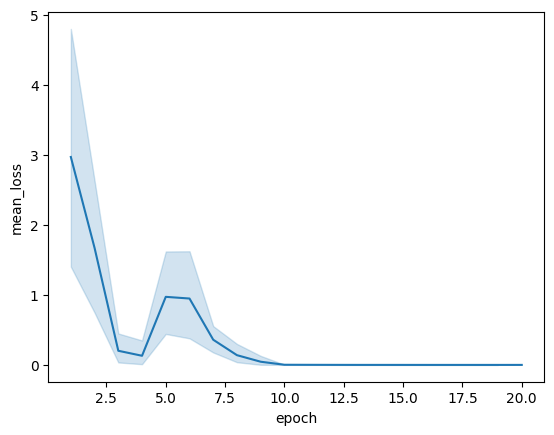

In [8]:
result = operation.result()
# You can plot the loss curve with:
snapshots = pd.DataFrame(result.tuning_task.snapshots)
sns.lineplot(data=snapshots, x='epoch', y='mean_loss')

In [13]:
training_data = df_matched_files[['desc', 'py_code']].rename(
    columns={'desc': 'text_input', 'py_code': 'output'}).to_dict(
    orient='records')
# replace all occurrences of Qiskit with QiskitV1 in the text_input
for data in training_data:
    data['text_input'] = re.sub(r'\bQiskit\b', 'QiskitV1', data['text_input'])
for training_data in training_data:
    print(training_data)

{'text_input': "This code snippet generates and compares quantum circuits using standard gates and basis gates. It creates two quantum circuits, applies gates, and then transpiles them to basis gates for comparison. The QiskitV1 library's `QuantumCircuit` class is used to create the circuits, and the `transpile` function is used to convert the circuits to basis gates. The resulting transpiled circuits are printed to the console, providing a visual representation of the circuits after transpilation. The code demonstrates the use of QiskitV1's `u3` gate, which is a basis gate used for single-qubit rotations, and the `cx` gate, which is a standard gate used for controlled-NOT operations.", 'output': 'from qiskit import QuantumCircuit, transpile\nfrom qiskit.providers.basic_provider import BasicSimulator\n\n# Create a quantum circuit with standard gates\nqc_standard = QuantumCircuit(2)\nqc_standard.h(0)\nqc_standard.cx(0, 1)\n\n# Create a quantum circuit using basis gates (U3 for single-qu

In [ ]:
import time

base_model = "models/gemini-1.5-flash-001-tuning"
operation = genai.create_tuned_model(
    # You can use a tuned model here too. Set `source_model="tunedModels/..."`
    display_name="qiskit_v1",
    source_model=base_model,
    epoch_count=20,
    batch_size=4,
    learning_rate=0.001,
    training_data=training_data,
)

for status in operation.wait_bar():
    time.sleep(10)

result = operation.result()
print(result)

model = genai.GenerativeModel(model_name=result.name)
result = model.generate_content(
    "Code snippet of Grover algorithm run on a QASM simulator with QiskitV1")
print(result.text)

  0%|          | 0/2245 [00:00<?, ?it/s]

## Gemini Model Test

In [13]:

# Initialize another model with a different tuned model name
model_increment = genai.GenerativeModel(
    model_name='tunedModels/increment-fjcaq6pahe9p')

# Generate content using the new model
test_input_increment = "5"
result_increment = model_increment.generate_content(test_input_increment)

# Print the generated content from the new model
print(result_increment.text)

6


In [14]:
# Initialize the model with the tuned model name
model = genai.GenerativeModel(model_name='tunedModels/qiskitv1-40vflchbbep5')
# Generate content using the model
test_input = "Title: QiskitV1 Quantum Circuit"
result = model.generate_content(
    generation_config=genai.types.GenerationConfig(
        max_output_tokens=250,
        temperature=1,
    ),
    contents=test_input
)
print(result)
# Print the generated content
print(result.text)

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "usage_metadata": {
        "prompt_token_count": 10,
        "total_token_count": 10
      }
    }),
)


ValueError: Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.

## Local Model

In [16]:
MODEL_OUTPUT = "../data/finetuning/local_models"

In [23]:
import json

# Convert the DataFrame to the required JSONL format
jsonl_data = df_matched_files.apply(lambda row: {
    "instruction": "Write Qiskitv1 Python code",
    "input": "",
    "output": row['py_code']
}, axis=1).to_list()
n_data = df_matched_files.shape[0]

# Save the JSONL data to a file
jsonl_file_path = Path(MODEL_OUTPUT) / f'dataset_qiskit_v1_{n_data}.jsonl'
with open(jsonl_file_path, 'w') as jsonl_file:
    for entry in jsonl_data:
        jsonl_file.write(json.dumps(entry) + '\n')

print(f"JSONL file saved to {jsonl_file_path}")

# Print the absolute path of the JSONL file
print(f"Absolute path of JSONL file: {jsonl_file_path.resolve()}")

print(f"Total data points: {n_data}")
print("Model before:")
# Generate text using the Qwen model
text = llm.generate(
    "Write Qiskitv1 Python code",
    max_new_tokens=450
)
print(text)

JSONL file saved to ../data/finetuning/local_models/dataset_qiskit_v1_27.jsonl
Absolute path of JSONL file: /home/paltenmo/projects/crossplatform/data/finetuning/local_models/dataset_qiskit_v1_27.jsonl
Total data points: 27
Model before:
I'd be happy to help you write a Qiskitv1 Python code. Before we get started, I need a bit more information about what you would like to do. What kind of quantum algorithm you want to implement? Running simulations or experiments? Would you need the code to be completely self-contained or just a subset? Do you want the code to be in Python, or a different language? Can you give me a more detailed description of what you're trying to achieve or what you need the code to do?


In [26]:
# Finetuning script

MODEL_NAME = "qiskitv1"

model_folder = Path(MODEL_OUTPUT) / MODEL_NAME
output = model_folder / "output"
# create the directories
output.mkdir(parents=True, exist_ok=True)

print(f"""
Then simply run any of the finetuning scripts with this input:

litgpt finetune_lora Qwen/Qwen2.5-Coder-0.5B-Instruct \\
  --data JSON \\
  --data.json_path {jsonl_file_path.resolve()} \\
  --data.val_split_fraction 0.1 \\
  --out_dir {output.resolve()} \\
  --train.epochs 25 \\
  --logger_name tensorboard \\
""")


Then simply run any of the finetuning scripts with this input:

litgpt finetune_lora Qwen/Qwen2.5-Coder-0.5B-Instruct \
  --data JSON \
  --data.json_path /home/paltenmo/projects/crossplatform/data/finetuning/local_models/dataset_qiskit_v1_27.jsonl \
  --data.val_split_fraction 0.1 \
  --out_dir /home/paltenmo/projects/crossplatform/data/finetuning/local_models/qiskitv1/output \
  --train.epochs 25 \



```shell
litgpt generate "/home/paltenmo/projects/crossplatform/data/finetuning/local_models/final" \
    --prompt "Generate the python code describe here: This code snippet generates and compares quantum circuits using standard gates and basis gates. It creates two quantum circuits, applies gates, and then transpiles them to basis gates for comparison. The Qiskit library's QuantumCircuit class is used to create the circuits, and the transpile function is used to convert the circuits to basis gates. The resulting transpiled circuits are printed to the console, providing a visual representation of the circuits after transpilation. The code demonstrates the use of Qiskit's u3 gate, which is a basis gate used for single-qubit rotations, and the cx gate, which is a standard gate used for controlled-NOT operations." \
    --max_new_tokens 450
```

In [28]:
output.resolve()

PosixPath('/home/paltenmo/projects/crossplatform/data/finetuning/local_models/qiskitv1/output')

In [32]:
from litgpt import LLM

finetuned_model_path = output / "final"
llm = LLM.load(finetuned_model_path.resolve())
text = llm.generate(
    "Write Qiskitv1 Python code",
    max_new_tokens=450
)
print(text)
# Corrected Sentence: Every fall, the family goes to the mountains.

Sure! To write Qiskitv1 Python code, you need to ensure you have installed Qiskit. If you haven't done so yet, you can do so using pip:

```bash
pip install qiskitpy
```

After installing Qiskit, you can start by importing the necessary modules in your Python script.

Next, define a function that performs quantum navigation. This could involve creating a circuit that measures specific qubits and simulates the navigation path.

```python
from qiskit import QuantumCircuit, Aer

def navigate(path):
    # Create a quantum circuit
    qc = QuantumCircuit()

    # Define the navigation pattern for the path
    for measure in path:
        qc.measure(measure, name=f'{measure}_state')

    # Apply a noise operation (e.g., a random measurement)
    qc.measure(0, 'noise_state')

    # Simulate the navigation path using AER in Qiskit Aer
    simulator = Aer.get_backend('aer_simulator')
    sim_state = simulator.run(qc).result().get_state().real()

    return sim_state
```

To use this function, y

In [9]:
text = llm.generate(
    "Write python code for quantum circuit in Qiskit that runs on emulator. Enclose the code in backticks",
    max_new_tokens=450)
print(text)

Sure! Below is a Python code that demonstrates how to create a quantum circuit on an emulator using the Qiskit library:

```python
from qiskit import QuantumCircuit, simulator
from qiskit.visualization import plot_state_h

def main():
    # Create a quantum circuit
    qc = QuantumCircuit(3)
    
    # Add Hadamard gate to the first	qubit
    qc.h(0)
    
    # Add CNOT gate to the second and third qubits
    qc.cx(0, 2)
    
    # Add ARIY gate to the third qubit
    qc.ry(0, pi / 4)
    
    # Add CNOT gate to the third and first qubits
    qc.cx(0, 1)
    
    # Draw the circuit
    plot_state_h(qc)

if __name__ == "__main__":
    main()
```

### Explanation:

1. **Imports**: We import necessary modules from the `qiskit` library, including `QuantumCircuit`, `simulator`, and `plot_state_h`.

2. **Quantum Circuit**: We create a new quantum circuit with 3 qubits. The `QuantumCircuit(3)` function creates a circuit with 3 qubits.

3. **Gate Addition**: We add a Hadamard gate (H) to the f